# Introduction

Goals:

* Assess the difference in $\phi$-$\psi$ movement for the CDR loops versus Fw region of TCRs in *apo* and *holo* forms
* Determine where the "hinge" point might be- if any

In [91]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from python_pdb.parsers import parse_pdb_to_pandas
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [30]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned'

# Calculating $\phi$ and $\psi$ angles

## Helper Functions

In [31]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

In [22]:
def calculate_angle(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    
    cos_theta = np.dot(v1, v2) / (n1 * n2)
    
    cos_theta = min(cos_theta, 1)
    cos_theta = max(cos_theta, -1)
    
    return np.arccos(cos_theta)

def calculate_dihedral_angle(a, b, c, d):
    ba = a - b
    bc = c - b
    cd = d - c
    
    u = np.cross(ba, bc)
    v = np.cross(cd, bc)
    
    w = np.cross(u, v)
    
    angle = calculate_angle(u, v)
    
    if calculate_angle(bc, w) > 0.001:
        angle = -angle

    return angle

def calculate_phi_psi_angles(residue: pd.DataFrame, prev_residue: pd.DataFrame, next_residue: pd.DataFrame) -> tuple[float, float]:
    '''Calculate the dihedral (phi and psi) angles for a given residue.'''
    c_prev_pos = prev_residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    n_pos = residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    ca_pos = residue.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    c_pos = residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]

    n_next_pos = next_residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    phi_angle = calculate_dihedral_angle(c_prev_pos, n_pos, ca_pos, c_pos)
    psi_angle = calculate_dihedral_angle(n_pos, ca_pos, c_pos, n_next_pos)
    
    return (phi_angle, psi_angle)

## Calculations

In [35]:
groups = []
paths = []

cdrs = []
chain_types = []

res_names = []
seq_ids = []
insert_codes = []

phis = []
psis = []

for group in (dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))):
    print(group)
    
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path in pdb_files:
        print(path)
        chains = get_chain_assignments(path)
        
        with open(os.path.join(DATA_DIR, group, path), 'r') as fh:
            structure_df = parse_pdb_to_pandas(fh.read())

        structure_df['chain_type'] = structure_df['chain_id'].map(chains)
        
        tcr_df = structure_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'").copy()

        tcr_var_df = tcr_df.query('residue_seq_id <= 128')

        for chain_type in ('alpha_chain', 'beta_chain'):
            chain_df = tcr_var_df.query('chain_type == @chain_type')

            residues = list(chain_df.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False))
            num_residues = len(residues)

            for i, ((res_name, seq_id, insert_code), res) in enumerate(residues):
                if i == 0 or i == num_residues - 1:
                    continue

                prev_res = residues[i - 1][-1]
                next_res = residues[i + 1][-1]

                phi, psi = calculate_phi_psi_angles(res, prev_res, next_res)
                
                groups.append(group)
                paths.append(path)
                
                chain_types.append(chain_type)

                res_names.append(res_name)
                seq_ids.append(seq_id)
                insert_codes.append(insert_code)

                phis.append(phi)
                psis.append(psi)

results = pd.DataFrame({
    'group': groups,
    'path': paths,
    'chain': chain_types,
    'res_name': res_names,
    'seq_id': seq_ids,
    'insert_code': insert_codes,
    'phi': phis,
    'psi': psis,
})

YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGAGGADTQY
7n1c_DE_apo.pdb
7n1e_DECA_holo.pdb
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQEGDTQY
6at6_AB_apo.pdb
6avf_ABPH_holo.pdb
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY
3vxt_AB_apo.pdb
3vxu_DECA_holo.pdb
3w0w_DECA_holo.pdb
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
6vth_DE_apo.pdb
6vrm_DEPA_holo.pdb
YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
1g6r_ABPH_holo.pdb
2ckb_CDQI_holo.pdb
1mwa_ABPH_holo.pdb
2oi9_BCQA_holo.pdb
1tcr_AB_apo.pdb
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY
5nmf_DECA_holo.pdb
5nmd_AB_apo.pdb
5nmg_DECA_holo.pdb
5nme_IJHF_holo.pdb
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY
7n1f_DECA_holo.pdb
7rtr_DECA_holo.pdb
7n1d_AB_apo.pdb
FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGMGGWQ
4jff_DECA_holo.pdb
4jfe_DECA_holo.pdb
6eqb_DECA_holo.pdb
6tmo_DECA_holo.pdb
4jfd_DECA_holo.pdb
4jfh_DE_apo.pdb
SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY
5hhm_IJHF_holo.pdb
2vlm_DE_apo.pdb
1oga_DECA_holo.pd

In [36]:
results

,group,path,chain,res_name,seq_id,insert_code,phi,psi
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,alpha_chain,ALA,78,NaN,-2.402166,1.126937
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,alpha_chain,ALA,94,NaN,-2.370670,3.020537
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,alpha_chain,ALA,100,NaN,1.833180,-2.091816
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,alpha_chain,ALA,105,NaN,2.871356,3.107190
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,alpha_chain,ALA,112,NaN,0.986578,-0.439727
...,...,...,...,...,...,...,...,...
16465,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,beta_chain,VAL,57,NaN,-1.430406,0.205772
16466,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,beta_chain,VAL,71,NaN,0.070138,-0.219175
16467,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,beta_chain,VAL,78,NaN,2.482958,2.774214
16468,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,beta_chain,VAL,101,NaN,-0.589919,0.991253


In [40]:
results['state'] = results['path'].map(lambda path: path.split('_')[-1].split('.')[0])

In [45]:
apo_results = results.query("state == 'apo'")
holo_results = results.query("state == 'holo'")

matched_results = apo_results.merge(holo_results, on=['group', 'chain', 'res_name', 'seq_id', 'insert_code'], suffixes=('_apo', '_holo'))

In [46]:
matched_results['phi_change'] = matched_results['phi_holo'] - matched_results['phi_apo']
matched_results['psi_change'] = matched_results['psi_holo'] - matched_results['psi_apo']

In [52]:
results_norm = matched_results.groupby(
    ['group', 'chain', 'seq_id', 'insert_code', 'res_name'], dropna=False
).agg({'phi_change': 'mean', 'psi_change': 'mean'}).reset_index()

In [53]:
results_norm['phi_change_mag'] = results_norm['phi_change'].apply(np.abs)
results_norm['phi_change_mag_deg'] = results_norm['phi_change_mag'].apply(np.degrees)

results_norm['psi_change_mag'] = results_norm['psi_change'].apply(np.abs)
results_norm['psi_change_mag_deg'] = results_norm['psi_change_mag'].apply(np.degrees)

In [55]:
results_norm['resi'] = results_norm['seq_id'].apply(str) + results_norm['insert_code'].fillna('')

In [66]:
results_norm['cdr'] = results_norm['seq_id'].map(assign_cdr_number)

In [58]:
results_norm

,group,chain,seq_id,insert_code,res_name,phi_change,psi_change,phi_change_mag,phi_change_mag_deg,psi_change_mag,psi_change_mag_deg,resi,cdr
0,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha_chain,2,NaN,LYS,1.241257,0.172246,1.241257,71.118773,0.172246,9.868946,2,NaN
1,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha_chain,3,NaN,GLU,-0.419158,0.587829,0.419158,24.016009,0.587829,33.680141,3,NaN
2,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha_chain,4,NaN,VAL,0.085405,0.186847,0.085405,4.893318,0.186847,10.705561,4,NaN
3,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha_chain,5,NaN,GLU,-1.517781,0.286408,1.517781,86.962462,0.286408,16.409998,5,NaN
4,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,alpha_chain,6,NaN,GLN,0.299766,1.137878,0.299766,17.175350,1.137878,65.195583,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta_chain,123,NaN,ARG,-0.052748,0.008210,0.052748,3.022231,0.008210,0.470397,123,NaN
3942,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta_chain,124,NaN,LEU,-0.012015,0.045576,0.012015,0.688412,0.045576,2.611306,124,NaN
3943,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta_chain,125,NaN,THR,-0.155402,-0.045042,0.155402,8.903863,0.045042,2.580728,125,NaN
3944,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,beta_chain,127,NaN,LEU,-0.017923,0.000727,0.017923,1.026887,0.000727,0.041645,127,NaN


## Visualize Results

<Axes: xlabel='cdr', ylabel='phi_change_mag_deg'>

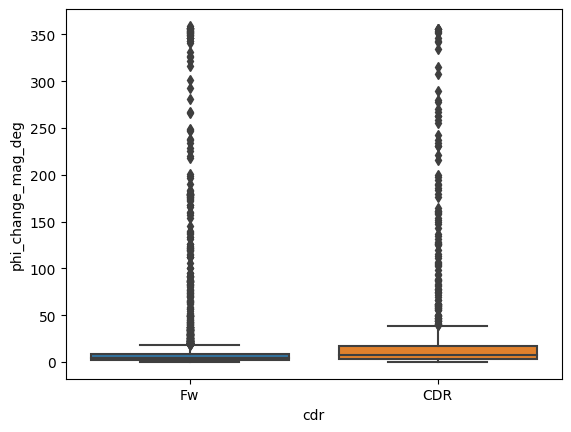

In [90]:
fw_or_cdr = results_norm['cdr'].map(lambda cdr: 'Fw' if pd.isnull(cdr) else 'CDR')
sns.boxplot(results_norm,
            x=fw_or_cdr,
            y='phi_change_mag_deg')

In [96]:
phi_fw_changes = results_norm[fw_or_cdr == 'Fw']['phi_change_mag_deg'].to_numpy()
phi_cdr_changes = results_norm[fw_or_cdr == 'CDR']['phi_change_mag_deg'].to_numpy()

print('Fw phi changes mean: ', np.mean(phi_fw_changes))
print('CDR phi changes mean: ', np.mean(phi_cdr_changes))

scipy.stats.ttest_ind(phi_fw_changes, phi_cdr_changes, alternative='less')

Fw phi changes mean:  14.148863630490945
CDR phi changes mean:  27.135067067914065


Ttest_indResult(statistic=-7.046759072312812, pvalue=1.0758355843616078e-12)

<Axes: xlabel='cdr', ylabel='psi_change_mag_deg'>

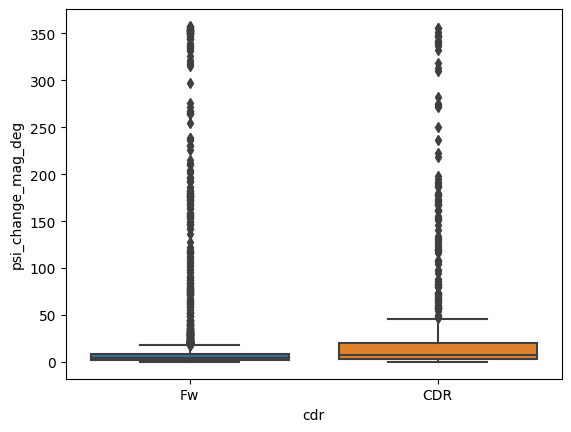

In [86]:
sns.boxplot(results_norm,
            x=fw_or_cdr,
            y='psi_change_mag_deg')

In [97]:
psi_fw_changes = results_norm[fw_or_cdr == 'Fw']['psi_change_mag_deg'].to_numpy()
psi_cdr_changes = results_norm[fw_or_cdr == 'CDR']['psi_change_mag_deg'].to_numpy()

print('Fw psi changes mean: ', np.mean(psi_fw_changes))
print('CDR psi changes mean: ', np.mean(psi_cdr_changes))

scipy.stats.ttest_ind(psi_fw_changes, psi_cdr_changes, alternative='less')

Fw psi changes mean:  16.874530946556515
CDR psi changes mean:  29.596532389409727


Ttest_indResult(statistic=-6.054755431312745, pvalue=7.687905480993475e-10)

## In progress...

In [76]:
palette = results_norm['cdr'].map(lambda cdr: 'red' if cdr == 1 else 'green' if cdr == 2 else 'blue' if cdr == 3 else 'grey')

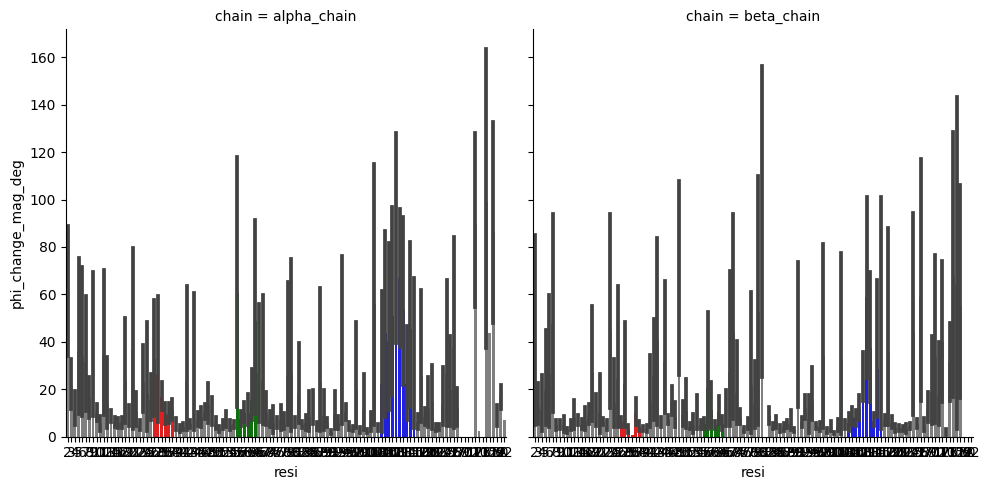

In [98]:
sns.catplot(results_norm,
            y='phi_change_mag_deg',
            x='resi',
            col='chain',
            kind='bar',
            palette=pallette)

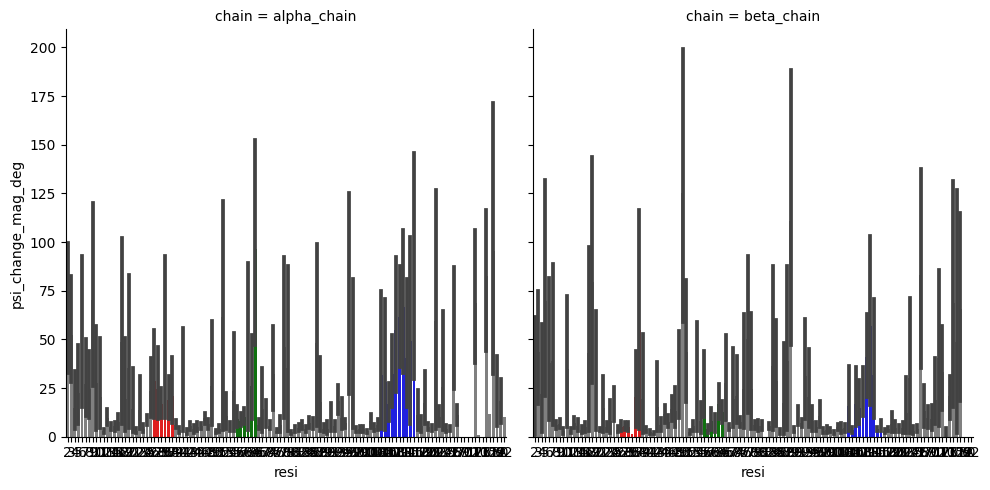

In [100]:
sns.catplot(results_norm,
            y='psi_change_mag_deg',
            x='resi',
            col='chain',
            kind='bar',
            palette=pallette)